In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Homework 3

For this homework, you will be working extensively in tensorflow. It is suggested that you spin up a Google Cloud VM with a GPU attached. Remember, instructions for doing so are found in Homework 0.

### Part 1: Homework 2, but on tensorflow
### Part 2: DNN on MNIST and CIFAR10
### Part 3: VGG on MNIST and CIFAR10
### (Optional) Part 4, getting state of the art (#SOTA)


# Part 1
You don't have to repeat everything in homework 2, but rather pick one set of two features that worked well for you last homework, and implement logistic regression using tensorflow without using keras (you will practice using keras in parts 2 and 3). In other words, using tensorflow operations, please create a scalar-value loss function and let tensorflow create the training operation for logistic regression, which automatically computes the gradients and updates the weight parameters. Note that the logistic loss is a special case of the softmax cross entropy loss that you've seen when classifying MNIST.

In [ ]:
# Import datasets
%matplotlib inline

from sklearn import datasets
import matplotlib.pyplot as plt
digits = datasets.load_digits()
# for index, (image, label) in enumerate(list(zip(digits.images, digits.target))[:10]):
#     plt.subplot(1, 10, index + 1)
#     plt.axis('off')
#     plt.imshow(image, cmap=plt.cm.gray_r)
#     plt.title('%i' % label)
# plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

number_a = 0
number_b = 3

digit_a_indexes = np.where(digits.target==number_a) 
digit_b_indexes = np.where(digits.target==number_b)
targets = np.concatenate((digits.target[digit_a_indexes], digits.target[digit_b_indexes]))
images = np.concatenate((digits.images[digit_a_indexes], digits.images[digit_b_indexes]))
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.1, random_state=42)

In [ ]:
def compute_features(vector):
    image = vector.reshape(8, 8) # get back original image shape
    def compute_feature_a(image):
        return np.mean(image*np.rot90(image, k = 2))
    def compute_feature_b(image):
        return np.mean(image)
    return compute_feature_a(image), compute_feature_b(image)

# Apply and plot your features
# for x train dataset
X_features_train = np.apply_along_axis(compute_features, 1, X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_features_a = X_features_train[np.where(y_train==number_a)]
X_features_b = X_features_train[np.where(y_train==number_b)]

# for x test dataset
X_features_test = np.apply_along_axis(compute_features, 1, X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
X_features_a_test = X_features_test[np.where(y_test==number_a)]
X_features_b_test = X_features_test[np.where(y_test==number_b)]


# for y train
y_train_label = np.copy(y_train)
y_train_label[y_train == number_a] = -1
y_train_label[y_train == number_b] = 1

# for y test
y_test_label = np.copy(y_test)
y_test_label[y_test == number_a] = -1
y_test_label[y_test == number_b] = 1

In [ ]:
# cast as a float32; in general, you will work with float32 inputs:
X_features_train = X_features_train.astype(np.float32)
X_features_test = X_features_test.astype(np.float32)
print(X_features_train.shape)
print(X_features_test.shape)

In [ ]:
y_train_label = y_train_label.astype(np.float32)
y_test_label = y_test_label.astype(np.float32)
print(y_train_label.shape)
print(y_test_label.shape)

In [ ]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 2], name='input_features')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 2

# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [ ]:
net = X_batch
# fully connected layers:
# net = tf.layers.flatten(net)
# net = tf.layers.dense(net, units=512, activation=tf.nn.relu) # was 256
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2) # was 10

logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits) # original depth = 10
# loss = tf.losses.log_loss(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits) # original depth = 10

In [ ]:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)

In [ ]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_features_train, y_train_or_test: y_train_label})
for i in range(1000):
    _, loss_i = sess.run([train_op, loss])
    if i%100 == 0:
        print(loss_i)

In [ ]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_features_test, y_train_or_test: y_test_label})
correct = 0
total = 0
for i in range(100):
    prediction, truth = sess.run([logits, y_batch])
    correct += np.sum(prediction.argmax(1)==truth)
    total += len(truth)
acc = correct/total
print(acc)

# Part 2:  DNN on MNIST and CIFAR10

In our lab, you guys saw how to work with the MNIST dataset to perform image classification. We can attempt the MNIST classification problem with just fully connected layers. This means we will be optimizing for non-banded matrices (no convolutions).

1. Calcualte the number of weight parameters you are optimizing for 1, 2 and 3 different fully connected layers (the total size of each layer is up to you).
2. What is the max layer depth you can go before training loss does not converge? You can usually tell that something is not converging by examining the training loss vs. iteration curve.
3. How does the number of parameters relate to the training loss and validation/test loss? Try to get a few data points to speak to this question.
3. Keeping the maximum number of parameters possible while still maintaining convergence (i.e., a good training and validation/test loss), what happens when you swap the activation function to `tanh` instead of `relu`? How about `sigmoid`?
4. After exploring the above, train a DNN model with the combination of hyperparameters that you believe will work best on MNIST.
5. Using the same architecture, try training a DNN model on more difficult dataset such as Fashion MNIST or CIFAR10/100. Example download instructions are shown in the next problem.

### Must haves
1. Make a curve of the final validation/test loss of your DNN after the loss plateaus as a function of the number of weight parameters used (final loss versus # parameters used). Note that you might see something like the curve below for a low number of parameters, but as the number of parameters increases, it will not look like this plot. 
2. On the same figure, make the same curve as above, but use different activation functions in your architecture.
3. Plot a point corresponding to your crafted DNN archiecture for question 4.
4. Repeat 1-3 for CIFAR10

The curves when reasonable # params are used look like the below
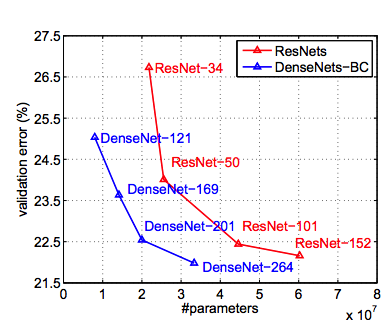

In [1]:
parameters = []
train_error = []
test_error = []

Training data shape (60000, 28, 28, 1)


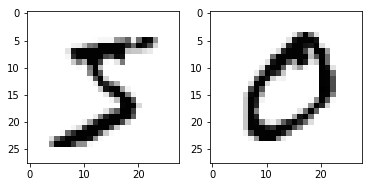

In [2]:
import tensorflow as tf
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data() #load dataset
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [3]:
model = tf.keras.Sequential([])
model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
for i in range(2):
    model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()
model.count_params()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


89610

In [4]:
model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy', #10 classes for output
              metrics=['accuracy']) # add mae: mean average error

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
hist = model.fit(X_train, y_train,
          batch_size=64,
          epochs=5,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[early_stop])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 47us/step - loss: 6.7714 - acc: 0.5736 - val_loss: 5.7552 - val_acc: 0.6405
Epoch 2/5
60000/60000 [==============================] - 2s 40us/step - loss: 5.8148 - acc: 0.6360 - val_loss: 5.4496 - val_acc: 0.6595
Epoch 3/5
60000/60000 [==============================] - 3s 43us/step - loss: 4.6816 - acc: 0.7068 - val_loss: 4.2817 - val_acc: 0.7322
Epoch 4/5
60000/60000 [==============================] - 2s 41us/step - loss: 4.3708 - acc: 0.7272 - val_loss: 4.2692 - val_acc: 0.7336
Epoch 5/5
60000/60000 [==============================] - 2s 39us/step - loss: 4.2808 - acc: 0.7330 - val_loss: 4.2867 - val_acc: 0.7330


In [38]:
# Build your DNN, an example model is given for you.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), #turn images into vectors; output will be 784*784*1
    tf.keras.layers.Dense(100, activation='relu'), #matrix multiplication --> 784*100 + bias https://keras.io/layers/core/
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') #output will be some size 10 vector
])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy', #10 classes for output
              metrics=['accuracy']) # add mae: mean average error
hist = model.fit(X_train, y_train,
          batch_size=64,
          epochs=5, # increase epochs number; set 50 training --> 
          verbose=1,
          validation_data=(X_val, y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 169us/step - loss: 0.4042 - acc: 0.8829 - val_loss: 0.2293 - val_acc: 0.9431
Epoch 2/5
60000/60000 [==============================] - 8s 126us/step - loss: 0.1907 - acc: 0.9526 - val_loss: 0.1797 - val_acc: 0.9547
Epoch 3/5
60000/60000 [==============================] - 8s 133us/step - loss: 0.1565 - acc: 0.9616 - val_loss: 0.1842 - val_acc: 0.9514
Epoch 4/5
60000/60000 [==============================] - 8s 129us/step - loss: 0.1369 - acc: 0.9667 - val_loss: 0.1531 - val_acc: 0.9644
Epoch 5/5
60000/60000 [==============================] - 7s 124us/step - loss: 0.1272 - acc: 0.9691 - val_loss: 0.1503 - val_acc: 0.9630


In [39]:
parameters.append(model.count_params())  #count parameters for you
print('parameter list: ', parameters)
train_error.append(100*(1-max(hist.history['acc'])))
print('train_error: ', train_error)
test_error.append(100*(1-max(hist.history['val_acc'])))
print('test_error: ', test_error)

parameter list:  [89610, 99710, 109810, 119910, 130010, 140110, 150210, 160310, 180510, 210810, 241110]
train_error:  [37.31333333333333, 26.565000000000005, 48.01166666666666, 3.2016666666666693, 2.9900000000000038, 2.8516666666666635, 2.7649999999999952, 2.811666666666668, 2.701666666666669, 2.856666666666663, 3.0850000000000044]
test_error:  [35.36, 25.860000000000007, 47.260000000000005, 3.820000000000001, 3.059999999999996, 3.63, 2.9299999999999993, 3.280000000000005, 3.4499999999999975, 3.610000000000002, 3.5599999999999965]


In [3]:
def plot_loss(parameters_list, train_errors_list, test_errors_list):
    ax = plt.subplot(111)
    ax.plot(parameters_list, train_errors_list,'r', label='train error')
    ax.plot(parameters_list, test_errors_list,'g', label='test error')
    ax.set(xlabel='# parameters', ylabel='validation error (%)')
    ax.legend()
    plt.title('ReLU Multiple Layers')
    plt.show()

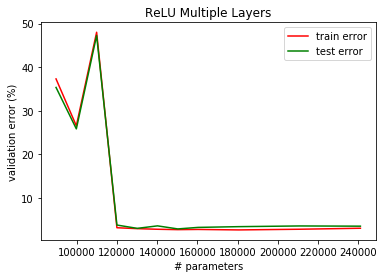

In [41]:
plot_loss(parameters, train_error, test_error)

# parameter list:  [89610, 99710, 109810, 119910, 130010, 140110, 150210, 160310, 180510, 210810, 241110]
# train_error:  [37.31333333333333, 26.565000000000005, 48.01166666666666, 3.2016666666666693, 2.9900000000000038, 2.8516666666666635, 2.7649999999999952, 2.811666666666668, 2.701666666666669, 2.856666666666663, 3.0850000000000044]
# test_error:  [35.36, 25.860000000000007, 47.260000000000005, 3.820000000000001, 3.059999999999996, 3.63, 2.9299999999999993, 3.280000000000005, 3.4499999999999975, 3.610000000000002, 3.5599999999999965]

In [4]:
# for tanh
parameters1 = []
train_error1 = []
test_error1 = []

In [ ]:
# Build your DNN, an example model is given for you.
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), #turn images into vectors; output will be 784*784*1
    tf.keras.layers.Dense(100, activation='relu'), #matrix multiplication --> 784*100 + bias https://keras.io/layers/core/
    tf.keras.layers.Dense(10, activation='softmax') #output will be some size 10 vector
])

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy', #10 classes for output
              metrics=['accuracy']) # add mae: mean average error
hist = model.fit(X_train, y_train,
          batch_size=64,
          epochs=5, # increase epochs number; set 50 training --> 
          verbose=1,
          validation_data=(X_val, y_val))

In [ ]:
parameters1.append(model.count_params())  #count parameters for you
print('parameter list: ', parameters1)
train_error1.append(100*(max(hist.history['acc'])))
print('train_error: ', train_error1)
test_error1.append(100*(max(hist.history['val_acc'])))
print('test_error: ', test_error1)

In [3]:
parameters = []
train_error = []
test_error = []

In [3]:
n = 5
for i in range(n):
    model = tf.keras.Sequential([])
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    for i in range(n+1):
        model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
        
    model.compile(optimizer=tf.train.AdamOptimizer(0.001),
                  loss='categorical_crossentropy', #10 classes for output
                  metrics=['accuracy']) # add mae: mean average error
    model.summary()
        
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3)
    # tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/{}'.format('model_name'))
    hist = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=5,
                         verbose=1,
                         validation_data=(X_val, y_val),
                         callbacks=[early_stop])
    
#     train_error.append(100*(1-max(hist.history['acc'])))
#     print('train_error: ', train_error)
#     test_error.append(100*(1-max(hist.history['val_acc'])))
#     print('test_error: ', test_error)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
__________

KeyboardInterrupt: 

In [4]:
print('parameter list: ', parameters)
print('train_error: ', train_error)
print('test_error: ', test_error)
plot_loss(parameters, train_error, test_error)

parameter list:  []
train_error:  []
test_error:  []


NameError: name 'plot_loss' is not defined

In [ ]:
# tensorboard

# Part 3. VGG on CIFAR100 and CIFAR10

VGG is a simple, but powerful CNN created in 2015. Read the VGG paper here: https://arxiv.org/pdf/1409.1556.pdf

Here, we're going to try to reproduce the model's findings on the cifar10 and cifar100 dataset. Note that the paper takes 224 x 224 images, but cifar10 and 100 are only 32 x 32 images.

1. Implement all of the layers for the VGG ConvNet Configuration A. Please use the shell code below as guide. Then, train this network on the Cifar10 and Cifar100 datasets.
2. For Cifar10 and 100, VGG is probably overkill. Try changing the number of layers and number of filters without sacrificing too much performance accuracy. How many filters can you get rid of before you see the accuracy drop by more than 2%? Where in the architecture is it better to remove filters - towards the input layers, or more towards the output layers?
3. For what you experiment with--report the parameter, validation loss curves for changing the number of i) layers, ii) filter size, iii) both.

170500096/170498071 [==============================] - 47s 0us/step
Training data shape (50000, 32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               2097664   
___________________________________

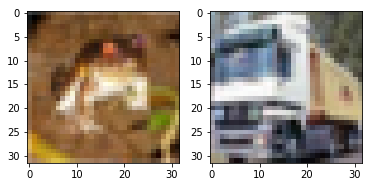

In [4]:
# This is the same model in the other notebook, looks very simplified.
import tensorflow as tf
(X_train, y_train), (X_val, y_val) = tf.keras.datasets.cifar10.load_data() #32*32 RGB vectors
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(32, 32, 3));
ax2.imshow(X_train[1].reshape(32, 32, 3));

# Example CNN used in class
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(padding='same'),
    
    tf.keras.layers.Conv2D(64, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
early_stop = tf.keras,callbacks.Earlystopping(monitor='val_loss', min_delta=1e-3, patience=3)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs{}'.format('model_1'))

hist = model.fit(X_train, y_train,
          batch_size=64,
          epochs=1, # increase epochs number
          verbose=1,
          validation_data=(X_val, y_val), callbacks=[early_stop, tensorboard])
    

# (Optional) Part 4, state of the art

Currently, state of the art implementations in the image classification problem are DenseNet: (https://arxiv.org/abs/1608.06993), ResNet (https://arxiv.org/abs/1512.03385), and ResNext (https://arxiv.org/pdf/1611.05431.pdf). Try implementing and training one of these on the cifar10 and cifar100 dataset. Feel free to experiment.

Jargon to learn about
1. What is "residual learning"?


2. What is a "bottleneck layer"?


3. What is a "dense block"?